In [48]:
import csv
from collections import defaultdict
import pandas as pd
import numpy as np
import sqlite3 as sql
import time
import requests
import json
import logging
from random import randint
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


DB_NAME = 'main.db'


NEW_BUILD = {"N": 0,
             "Y": 1}

HOUSE_TYPE ={"D":1,
             "S":2,
             "O":9,
             "T":3,
             "F":4}

CRIME_SCORE = { "bicycle-theft":4,
                "burglary":10,
               "criminal-damage-arson":9,
               "drugs":6,
               "other-theft":8,
               "possession-of-weapons:":10,
               "robbery":10,
               "shoplifting":4,
               "theft-from-the-person" :7,
               "vehicle-crime" : 10,
               "violent-crime": 10               
              }



broadband_table = """CREATE TABLE IF NOT EXISTS broadband_table (
                               admin_ward_code TEXT  NOT NULL,
                               broadband_speed int,
                               FOREIGN KEY (admin_ward_code) REFERENCES administration_ward(admin_ward_code)
                                ); """


crime_table  = """
            CREATE TABLE IF NOT EXISTS crime_table (
            postcode TEXT NOT NULL,
            crime_score int,
            PRIMARY KEY (postcode)
            );
                """


main_properties_table = """

            CREATE TABLE IF NOT EXISTS main_table_properties(
              id TEXT,
              postcode TEXT,
              admin_ward_code TEXT,
              PRIMARY KEY (id),
              FOREIGN KEY (postcode) REFERENCES crime_table(postcode),
              FOREIGN KEY (admin_ward_code) REFERENCES administration_ward(admin_ward_code)
            );
            """


house_information_table = """
                    CREATE TABLE IF NOT EXISTS house_information(
                      id TEXT,
                      admin_ward_code TEXT,
                      price int,
                      build_type int,
                      new_build int,
                      FOREIGN KEY (id) REFERENCES main_table_properties(id),
                      FOREIGN KEY (admin_ward_code) REFERENCES administration_ward(admin_ward_code)

                    );
                    """
admin_ward_table = """ CREATE TABLE IF NOT EXISTS administration_ward(
                    admin_ward_code TEXT, 
                    ward_name TEXT,
                    PRIMARY KEY(admin_ward_code)
                    );

                        """



leicestershire_houses = pd.read_csv('leicestershire_month_april_houses.csv')
broadband_performance = pd.read_csv('broadband_speed.csv')

In [6]:
def create_connection(db_file):
    conn = None
    try:
        conn = sql.connect(db_file)
        return conn
    except Error as e:
        print("dunno", e)

    return conn

In [7]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [8]:
def get_postcode_info_api(postcode):
    try: 
        api_string_req = 'http://127.0.0.1:8000/postcodes/{code}'.format(code = postcode)
        r = requests.get(api_string_req).json()
        return r['result']
    except Exception as e:
        return None


In [9]:
def create_sql_tables():
    conn = create_connection(DB_NAME)
    if conn is not None:
        create_table(conn, broadband_table)
        create_table(conn, crime_table)
        create_table(conn, main_properties_table)
        create_table(conn, house_information_table)
        create_table(conn, admin_ward_table)

    else:
        print("Error! cannot create the database connection.")

In [10]:
def get_crime_external_api(lat,long,postcode,cursor):
    try:
        sql_statement = """SELECT crime_score from crime_table WHERE postcode == {p} """.format(p = "'{}'".format(postcode))
        cursor.execute(sql_statement)
        crime_score = cursor.fetchall()
        if len(crime_score) == 0:
            raise Exception("crime rate not in database, external api must be used.")
        else:
            return crime_score
    except Exception as e:
        print(e)
        pass
    crime_score = 0
    for month in range(1,13):
        api_string_req = 'https://data.police.uk/api/crimes-at-location?date=2018-{month}&lat={lat}&lng={long}'.format(lat=lat,long=long, month= month)
        try:
            r = requests.get(api_string_req).json()
            for crime_data in r:
                try:
                    category = crime_data['category']
                    crime_score += CRIME_SCORE[category]
                except KeyError:
                    continue
        except Exception as e:
            print(e)
            continue
    try:
        sql_statement_crime = """ INSERT INTO crime_table
        (postcode,crime_score) 
        VALUES ({pc}, {cr})""".format(
            pc = '"{}"'.format(postcode), 
            cr = crime_score)
   
        cursor.execute(sql_statement_crime)
    except:
        pass
    return crime_score

In [11]:
def get_df_z_score(main_df):
    z_score_df = main_df[['price', 'crime_score', 'broadband_speed']].copy()
    return stats.zscore(z_score_df)

In [12]:
def get_broadband_performance(admin_ward_code,cursor):
    broadband_speed = 0
    try:
        sql_statement = """SELECT broadband_speed FROM broadband_table WHERE admin_ward_code == {awc}""".format(awc = "'{}'".format(admin_ward_code))
        cursor.execute(sql_statement)
        broadband_speed = cursor.fetchall()
        if len(broadband_speed) == 0:
            raise Exception('Broadband speed not in database must be searched')
        return broadband_speed
    except Exception as e:
        print(e)
        for index,data in broadband_performance.iterrows():
            if data['id'] == admin_ward_code:
                broadband_speed = data['average']
                break
    insert_broadband = """INSERT INTO broadband_table(admin_ward_code, broadband_speed) VALUES ({admin_ward_code},{speed})""".format(admin_ward_code = "'{}'".format(admin_ward_code), speed = broadband_speed)
    print(insert_broadband)
    cursor.execute(insert_broadband)

In [13]:
def database_ward_insert(admin_ward_code, admin_district,cur):
    try:
        sql_statement = """INSERT INTO administration_ward(admin_ward_code, ward_name)
                        VALUES({awc}, {ad})
                        """.format(awc = "'{}'".format(admin_ward_code), ad = "'{}'".format(admin_district))
        cur.execute(sql_statement)
    except Exception as e:
        print(e)
        return

In [14]:
create_sql_tables()

In [15]:
def database_populate(sql_connection,csv_houses):
    cur = sql_connection.cursor()
    command = input("Heavy work ahead. hit Enter to continue...")
    times = 0
    cur = sql_connection.cursor()
    for index,data in csv_houses.iterrows():
        if times == 10:
            break
        times+=1
        house_postcode = data['postcode']
        unique_id = data['unique_id']
        house_price = data['price_paid']
        additional_data = get_postcode_info_api(house_postcode)
        print(additional_data)
        if additional_data is None:
            continue
        admin_district = additional_data['admin_district']
        new_build = NEW_BUILD[data['new_build']]
        house_type = HOUSE_TYPE[data['property_type']]
        admin_ward_code = additional_data['codes']['admin_ward']
        longitude = additional_data['longitude']
        latitude = additional_data['latitude']
        
        database_ward_insert(admin_ward_code, admin_district,cur)
        
        get_crime_external_api(latitude,longitude,house_postcode,cur)
        
        get_broadband_performance(admin_ward_code,cur)
    
        main_sql_statement = """ INSERT INTO main_table_properties
        (id,postcode,admin_ward_code) 
        VALUES ({id}, {pc}, {aw})""".format(
            aw = '"{}"'.format(admin_ward_code), 
            pc = '"{}"'.format(house_postcode), 
            id = '"{}"'.format(unique_id)
        )
        
        additional_info_sql = """ INSERT INTO house_information
        (id,admin_ward_code,price,build_type,new_build) 
        VALUES ({id}, {aw}, {pc}, {bt}, {nb})""".format(
            id = '"{}"'.format(unique_id), 
            aw = '"{}"'.format(admin_ward_code), 
            bt = house_type,
            nb = new_build,
            pc = house_price
        )
        
        print(additional_info_sql)
        try:
            
            cur.execute(main_sql_statement)
            cur.execute(additional_info_sql)
        except:
            continue
        

In [16]:
get_required_data()

NameError: name 'get_required_data' is not defined

In [46]:
def basic_recommandation_system(database_connection):
    database_connection = create_connection('main.db')
    cur = database_connection.cursor()
    pd.set_option("display.precision", 15)
    pd.set_option('display.float_format', '{:.5f}'.format)

    print("Select a level of importance from 1-10 for the following")
    crime_rate = int(input("Crime Rate:"))
    price = int(input("House Price:"))
    broadband = int(input("Broadband Speed:"))
    added_up = sum([crime_rate,price,broadband])
    user_crime_score = crime_rate / added_up
    user_price_score = price / added_up
    user_broadband_score = broadband / added_up
    sql_get_data_query = """
                    SELECT main_table_properties.id,main_table_properties.admin_ward_code,main_table_properties.postcode,price, broadband_speed, crime_score FROM main_table_properties
                    INNER JOIN house_information ON house_information.id = main_table_properties.id
                    INNER JOIN broadband_table ON broadband_table.admin_ward_code = main_table_properties.admin_ward_code
                    INNER JOIN crime_table ON crime_table.postcode = main_table_properties.postcode
                    """
    
    
    df = pd.read_sql_query(sql_get_data_query, database_connection)
    df["final_score"] = np.nan
    z_score = get_df_z_score(df)
    for index,data in df.iterrows():
        df.at[index,'final_score'] = z_score[index][0] * user_price_score +  z_score[index][1] * user_crime_score + (z_score[index][2] * -1) * user_broadband_score
    results = df.sort_values('final_score', ascending=True, kind="quicksort")
    print("There are the top 10 houses sold which fit your criteria best")
    print(results.head(10))

    best_locations = {}

    #check which location comes up the most out of the top 10 locations
    max_top = 10
    j = 0
    for index,data in results.iterrows():
        j+=1
        location = data["admin_ward_code"]
        if location in best_locations:
            best_locations[location] +=1
        else:
            best_locations[location] = 1
        if j == max_top:
            break
    locations_list_placeholder = []
    for key,value in best_locations.items():
        if value not in locations_list_placeholder:
            locations_list_placeholder.append(key)
    
    sql="SELECT ward_name FROM administration_ward WHERE admin_ward_code in ({seq})".format(
    seq=','.join(['?']*len(locations_list_placeholder)))

    cur.execute(sql,locations_list_placeholder)
    heaven = cur.fetchall()
    print("Best locations based on your criteria are:")
    for value in set(heaven):
        print(value[0])


In [47]:
basic_recommandation_system(1)

Select a level of importance from 1-10 for the following


Crime Rate: 10
House Price: 1
Broadband Speed: 1


[[-1.14869454 -0.55786339  0.91786247]
 [ 1.16257005 -0.57314732  0.91786247]
 [-0.51042078 -0.84825803  0.91786247]
 [-0.58970945 -0.4050241   0.91786247]
 [ 0.83748653 -0.23690089 -1.19851215]
 [ 0.4410432  -0.38974017 -1.19851215]
 [-0.76810894  0.92467767 -1.19851215]
 [-0.93065071  0.37445625 -1.19851215]
 [-0.51834965 -0.84825803  0.91786247]
 [ 2.02483429  2.56005801  0.20473624]]
There are the top 10 houses sold which fit your criteria best
                                     id admin_ward_code  postcode   price  \
8  98C75472-080F-72E9-E053-6B04A8C042F0       E05005480  CV13 0QE  209000   
2  87E1551E-52FB-6405-E053-6C04A8C0B2EE       E05005480  CV13 0HU  210000   
0  8CAC1318-6ABC-0253-E053-6B04A8C08E51       E05005480  CV13 0EF  129500   
3  87E1551E-542A-6405-E053-6C04A8C0B2EE       E05005480  CV13 0HX  200000   
1  87E1551E-5448-6405-E053-6C04A8C0B2EE       E05005480  CV13 0EH  421000   
5  87E1551E-53EA-6405-E053-6C04A8C0B2EE       E05005484  CV13 0NP  330000   
4  8A78B

In [82]:
# def item_based_collaborative_sys(database_connection):
#     df = pd.read_sql_query("SELECT * from leicester_warwick_shire_houses", database_connection)
#     random_scores = {305:10, 208:10, 704:10, 483:10, 946:10, 748:10, 630:10, 940:10, 939:10, 344:10}
#     df["user_score"] = 0
#     for key,value in random_scores.items():
#         df.at[key,"user_score"] = value
#     matrix_df = pd.DataFrame
#     matrix_df.append(df['user_score'])


In [85]:
# conn = create_connection(DB_NAME)
# item_based_collaborative_sys(conn)

In [21]:
def get_required_data():
    with sql.connect(DB_NAME) as con:
            database_populate(con,leicestershire_houses)

Heavy work ahead. hit Enter to continue... 


32.1


OperationalError: no such table: leicester_warwick_shire_houses

In [30]:
con = create_connection(DB_NAME)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df = pd.read_sql_query("SELECT * from leicester_warwick_shire_houses", con)
df.describe()

,id,price,type,new_build,crime_score,broadband_speed
count,971,971,971,971,971,971
mean,486,240690,2,0,46,49
std,280,118237,1,0,57,15
min,1,60000,1,0,0,18
25%,244,168000,1,0,10,31
50%,486,211000,2,0,28,54
75%,728,289998,3,0,62,62
max,971,1375000,4,1,375,78


<AxesSubplot:>

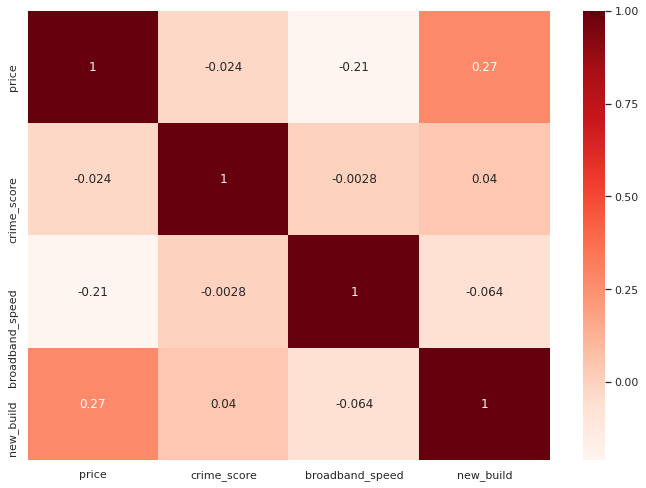

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df[['price','crime_score','broadband_speed','new_build']].corr(), annot=True, cmap = 'Reds')

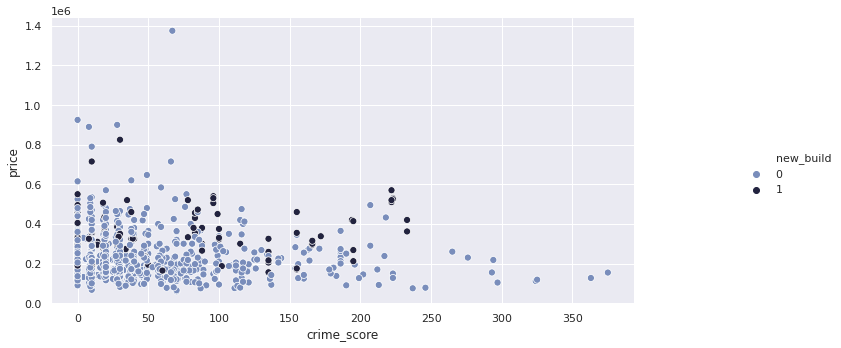

In [14]:
price = df['price']
g = sns.relplot(x="crime_score", y="price", hue="new_build", palette="ch:r=-.1,l=.55", data=df,s=50);
g.fig.set_size_inches(13,5)


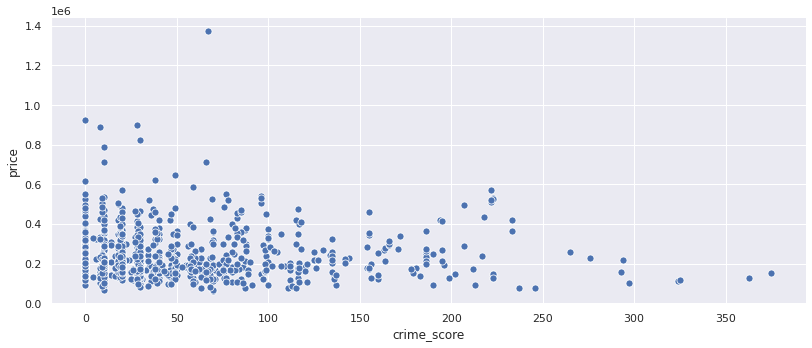

In [17]:
price = df['price']
g = sns.relplot(x="crime_score", y="price", palette="ch:r=-.25,l=.85", data=df,s=50);
g.fig.set_size_inches(13,5)


<AxesSubplot:xlabel='type', ylabel='price'>

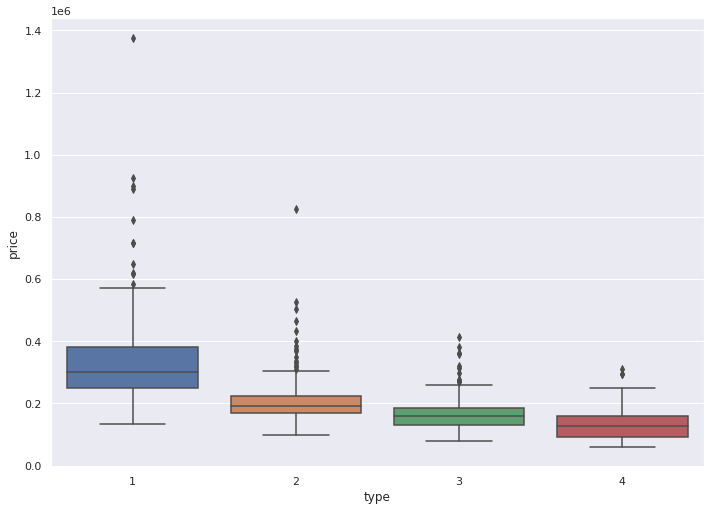

In [22]:
sns.boxplot(y='price',x='type',data=df)

In [16]:
# get_required_data()  # Data is already provided no need to execute

In [52]:
con = create_connection(DB_NAME)
basic_recommandation_system(con)

NameError: name 'basic_recommandation_system' is not defined

In [121]:
def multiple_regression(df):
    X = df[['crime_score','new_build','broadband_speed']]
    Y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)
    model = LinearRegression()
    model.fit(X_train,y_train)
#     print(model.intercept_)
    coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
    print(coeff_parameter)
    
    predictions = model.predict(X_test)
    sns.regplot(y_test,predictions)
    X_train_Sm= sm.add_constant(X_train)
    X_train_Sm= sm.add_constant(X_train)
    ls=sm.OLS(y_train,X_train_Sm).fit()
    print(ls.summary())


                 Coefficient
crime_score              -21
new_build              78110
broadband_speed        -1793
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     24.51
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           6.08e-15
Time:                        11:38:57   Log-Likelihood:                -7601.9
No. Observations:                 582   AIC:                         1.521e+04
Df Residuals:                     578   BIC:                         1.523e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------

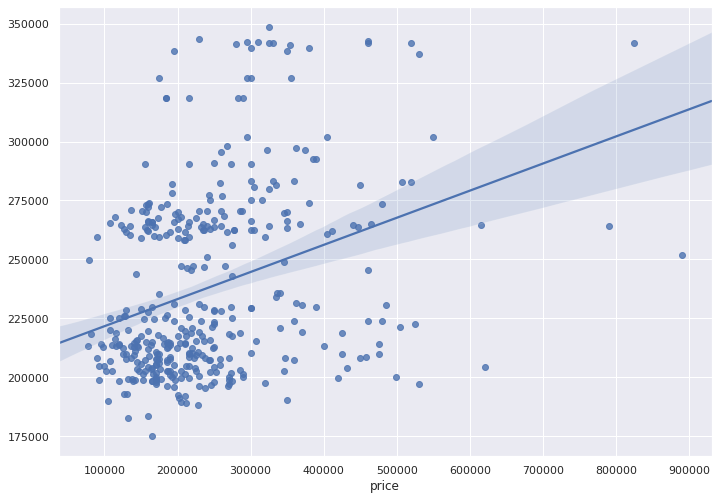

In [122]:
multiple_regression(df)